The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.16.0


# Statistics
:label:`sec_statistics`

Undoubtedly, to be a top deep learning practitioner, the ability to train the state-of-the-art and high accurate models is crucial.  However, it is often unclear when improvements are significant, or only the result of random fluctuations in the training process.  To be able to discuss uncertainty in estimated values, we must learn some statistics.


The earliest reference of *statistics* can be traced back to an Arab scholar Al-Kindi in the $9^{\mathrm{th}}$-century, who gave a detailed description of how to use statistics and frequency analysis to decipher encrypted messages. After 800 years, the modern statistics arose from Germany in 1700s, when the researchers focused on the demographic and economic data collection and analysis. Today, statistics is the science subject that concerns the collection, processing, analysis, interpretation and visualization of data. What is more, the core theory of statistics has been widely used in the research within academia, industry, and government.


More specifically, statistics can be divided to *descriptive statistics* and *statistical inference*. The former focus on summarizing and illustrating the features of a collection of observed data, which is referred to as a *sample*. The sample is drawn from a *population*, denotes the total set of similar individuals, items, or events of our experiment interests. Contrary to descriptive statistics, *statistical inference* further deduces the characteristics of a population from the given *samples*, based on the assumptions that the sample distribution can replicate the population distribution at some degree.


You may wonder: “What is the essential difference between machine learning and statistics?” Fundamentally speaking, statistics focuses on the inference problem. This type of problems includes modeling the relationship between the variables, such as causal inference, and testing the statistically significance of model parameters, such as A/B testing. In contrast, machine learning emphasizes on making accurate predictions, without explicitly programming and understanding each parameter's functionality.


In this section, we will introduce three types of statistics inference methods: evaluating and comparing estimators, conducting hypothesis tests, and constructing confidence intervals. These methods can help us infer the characteristics of a given population, i.e., the true parameter $\theta$. For brevity, we assume that the true parameter $\theta$ of a given population is a scalar value. It is straightforward to extend to the case where $\theta$ is a vector or a tensor, thus we omit it in our discussion.



## Evaluating and Comparing Estimators

In statistics, an *estimator* is a function of given samples used to estimate the true parameter $\theta$. We will write $\hat{\theta}_n = \hat{f}(x_1, \ldots, x_n)$ for the estimate of $\theta$ after observing the samples {$x_1, x_2, \ldots, x_n$}.

We have seen simple examples of estimators before in section :numref:`sec_maximum_likelihood`.  If you have a number of samples from a Bernoulli random variable, then the maximum likelihood estimate for the probability the random variable is one can be obtained by counting the number of ones observed and dividing by the total number of samples.  Similarly, an exercise asked you to show that the maximum likelihood estimate of the mean of a Gaussian given a number of samples is given by the average value of all the samples.  These estimators will almost never give the true value of the parameter, but ideally for a large number of samples the estimate will be close.

As an example, we show below the true density of a Gaussian random variable with mean zero and variance one, along with a collection samples from that Gaussian.  We constructed the $y$ coordinate so every point is visible and the relationship to the original density is clearer.


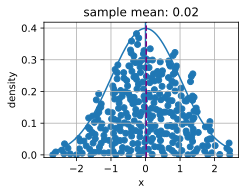

In [1]:
from d2l import tensorflow as d2l
import tensorflow as tf

tf.pi = tf.acos(tf.zeros(1)) * 2  # define pi in TensorFlow

# Sample datapoints and create y coordinate
epsilon = 0.1
xs = tf.random.normal((300,))

ys = tf.constant(
    [(tf.reduce_sum(tf.exp(-(xs[:i] - xs[i])**2 / (2 * epsilon**2)) \
               / tf.sqrt(2*tf.pi*epsilon**2)) / tf.cast(
        tf.size(xs), dtype=tf.float32)).numpy() \
     for i in range(tf.size(xs))])

# Compute true density
xd = tf.range(tf.reduce_min(xs), tf.reduce_max(xs), 0.01)
yd = tf.exp(-xd**2/2) / tf.sqrt(2 * tf.pi)

# Plot the results
d2l.plot(xd, yd, 'x', 'density')
d2l.plt.scatter(xs, ys)
d2l.plt.axvline(x=0)
d2l.plt.axvline(x=tf.reduce_mean(xs), linestyle='--', color='purple')
d2l.plt.title(f'sample mean: {float(tf.reduce_mean(xs).numpy()):.2f}')
d2l.plt.show()

There can be many ways to compute an estimator of a parameter $\hat{\theta}_n$.  In this section, we introduce three common methods to evaluate and compare estimators: the mean squared error, the standard deviation, and statistical bias.

### Mean Squared Error

Perhaps the simplest metric used to evaluate estimators is the *mean squared error (MSE)* (or $l_2$ loss) of an estimator can be defined as

$$\mathrm{MSE} (\hat{\theta}_n, \theta) = E[(\hat{\theta}_n - \theta)^2].$$
:eqlabel:`eq_mse_est`

This allows us to quantify the average squared deviation from the true value.  MSE is always non-negative. If you have read :numref:`sec_linear_regression`, you will recognize it as the most commonly used regression loss function. As a measure to evaluate an estimator, the closer its value to zero, the closer the estimator is close to the true parameter $\theta$.


### Statistical Bias

The MSE provides a natural metric, but we can easily imagine multiple different phenomena that might make it large.  Two fundamentally important are fluctuation in the estimator due to randomness in the dataset, and systematic error in the estimator due to the estimation procedure.


First, let us measure the systematic error. For an estimator $\hat{\theta}_n$, the mathematical illustration of *statistical bias* can be defined as

$$\mathrm{bias}(\hat{\theta}_n) = E(\hat{\theta}_n - \theta) = E(\hat{\theta}_n) - \theta.$$
:eqlabel:`eq_bias`

Note that when $\mathrm{bias}(\hat{\theta}_n) = 0$, the expectation of the estimator $\hat{\theta}_n$ is equal to the true value of parameter.  In this case, we say $\hat{\theta}_n$ is an unbiased estimator.  In general, an unbiased estimator is better than a biased estimator since its expectation is the same as the true parameter.


It is worth being aware, however, that biased estimators are frequently used in practice.  There are cases where unbiased estimators do not exist without further assumptions, or are intractable to compute.  This may seem like a significant flaw in an estimator, however the majority of estimators encountered in practice are at least asymptotically unbiased in the sense that the bias tends to zero as the number of available samples tends to infinity: $\lim_{n \rightarrow \infty} \mathrm{bias}(\hat{\theta}_n) = 0$.


### Variance and Standard Deviation

Second, let us measure the randomness in the estimator.  Recall from :numref:`sec_random_variables`, the *standard deviation* (or *standard error*) is defined as the squared root of the variance.  We may measure the degree of fluctuation of an estimator by measuring the standard deviation or variance of that estimator.

$$\sigma_{\hat{\theta}_n} = \sqrt{\mathrm{Var} (\hat{\theta}_n )} = \sqrt{E[(\hat{\theta}_n - E(\hat{\theta}_n))^2]}.$$
:eqlabel:`eq_var_est`

It is important to compare :eqref:`eq_var_est` to :eqref:`eq_mse_est`.  In this equation we do not compare to the true population value $\theta$, but instead to $E(\hat{\theta}_n)$, the expected sample mean.  Thus we are not measuring how far the estimator tends to be from the true value, but instead we measuring the fluctuation of the estimator itself.


### The Bias-Variance Trade-off

It is intuitively clear that these two main components contribute to the mean squared error.  What is somewhat shocking is that we can show that this is actually a *decomposition* of the mean squared error into these two contributions plus a third one. That is to say that we can write the mean squared error as the sum of the square of the bias, the variance and the irreducible error.

$$
\begin{aligned}
\mathrm{MSE} (\hat{\theta}_n, \theta) &= E[(\hat{\theta}_n - \theta)^2] \\
 &= E[(\hat{\theta}_n)^2] + E[\theta^2] - 2E[\hat{\theta}_n\theta] \\
 &= \mathrm{Var} [\hat{\theta}_n] + E[\hat{\theta}_n]^2 + \mathrm{Var} [\theta] + E[\theta]^2 - 2E[\hat{\theta}_n]E[\theta] \\
 &= (E[\hat{\theta}_n] - E[\theta])^2 + \mathrm{Var} [\hat{\theta}_n] + \mathrm{Var} [\theta] \\
 &= (E[\hat{\theta}_n - \theta])^2 + \mathrm{Var} [\hat{\theta}_n] + \mathrm{Var} [\theta] \\
 &= (\mathrm{bias} [\hat{\theta}_n])^2 + \mathrm{Var} (\hat{\theta}_n) + \mathrm{Var} [\theta].\\
\end{aligned}
$$

We refer the above formula as *bias-variance trade-off*. The mean squared error can be divided into three sources of error: the error from high bias, the error from high variance and the irreducible error. The bias error is commonly seen in a simple model (such as a linear regression model), which cannot extract high dimensional relations between the features and the outputs. If a model suffers from high bias error, we often say it is *underfitting* or lack of *flexibilty* as introduced in (:numref:`sec_model_selection`). The high variance usually results from a too complex model, which overfits the training data. As a result, an *overfitting* model is sensitive to small fluctuations in the data. If a model suffers from high variance, we often say it is *overfitting* and lack of *generalization* as introduced in (:numref:`sec_model_selection`). The irreducible error is the result from noise in the $\theta$ itself.


### Evaluating Estimators in Code

Since the standard deviation of an estimator has been implementing by simply calling `a.std()` for a tensor `a`, we will skip it but implement the statistical bias and the mean squared error.


In [2]:
# Statistical bias
def stat_bias(true_theta, est_theta):
    return(tf.reduce_mean(est_theta) - true_theta)

# Mean squared error
def mse(data, true_theta):
    return(tf.reduce_mean(tf.square(data - true_theta)))

To illustrate the equation of the bias-variance trade-off, let us simulate of normal distribution $\mathcal{N}(\theta, \sigma^2)$ with $10,000$ samples. Here, we use a $\theta = 1$ and $\sigma = 4$. As the estimator is a function of the given samples, here we use the mean of the samples as an estimator for true $\theta$ in this normal distribution $\mathcal{N}(\theta, \sigma^2)$ .


In [3]:
theta_true = 1
sigma = 4
sample_len = 10000
samples = tf.random.normal((sample_len, 1), theta_true, sigma)
theta_est = tf.reduce_mean(samples)
theta_est

<tf.Tensor: shape=(), dtype=float32, numpy=0.9737169>

Let us validate the trade-off equation by calculating the summation of the squared bias and the variance of our estimator. First, calculate the MSE of our estimator.


In [4]:
mse(samples, theta_true)

<tf.Tensor: shape=(), dtype=float32, numpy=16.020927>

Next, we calculate $\mathrm{Var} (\hat{\theta}_n) + [\mathrm{bias} (\hat{\theta}_n)]^2$ as below. As you can see, the two values agree to numerical precision.


In [5]:
bias = stat_bias(theta_true, theta_est)
tf.square(tf.math.reduce_std(samples)) + tf.square(bias)

<tf.Tensor: shape=(), dtype=float32, numpy=16.020926>

## Conducting Hypothesis Tests


The most commonly encountered topic in statistical inference is hypothesis testing. While hypothesis testing was popularized in the early 20th century, the first use can be traced back to John Arbuthnot in the 1700s. John tracked 80-year birth records in London and concluded that more men were born than women each year. Following that, the modern significance testing is the intelligence heritage by Karl Pearson who invented $p$-value and Pearson's chi-squared test, William Gosset who is the father of Student's t-distribution, and Ronald Fisher who initialed the null hypothesis and the significance test.

A *hypothesis test* is a way of evaluating some evidence against the default statement about a population. We refer the default statement as the *null hypothesis* $H_0$, which we try to reject using the observed data. Here, we use $H_0$ as a starting point for the statistical significance testing. The *alternative hypothesis* $H_A$ (or $H_1$) is a statement that is contrary to the null hypothesis. A null hypothesis is often stated in a declarative form which posits a relationship between variables. It should reflect the brief as explicit as possible, and be testable by statistics theory.

Imagine you are a chemist. After spending thousands of hours in the lab, you develop a new medicine which can dramatically improve one's ability to understand math. To show its magic power, you need to test it. Naturally, you may need some volunteers to take the medicine and see whether it can help them learn math better. How do you get started?

First, you will need carefully random selected two groups of volunteers, so that there is no difference between their math understanding ability measured by some metrics. The two groups are commonly referred to as the test group and the control group. The *test group* (or *treatment group*) is a group of individuals who will experience the medicine, while the *control group* represents the group of users who are set aside as a benchmark, i.e., identical environment setups except taking this medicine. In this way, the influence of all the variables are minimized, except the impact of the independent variable in the treatment.

Second, after a period of taking the medicine, you will need to measure the two groups' math understanding by the same metrics, such as letting the volunteers do the same tests after learning a new math formula. Then, you can collect their performance and compare the results.  In this case, our null hypothesis will be that there is no difference between the two groups, and our alternate will be that there is.

This is still not fully formal.  There are many details you have to think of carefully. For example, what is the suitable metrics to test their math understanding ability? How many volunteers for your test so you can be confident to claim the effectiveness of your medicine? How long should you run the test? How do you decide if there is a difference between the two groups?  Do you care about the average performance only, or also the range of variation of the scores? And so on.

In this way, hypothesis testing provides a framework for experimental design and reasoning about certainty in observed results.  If we can now show that the null hypothesis is very unlikely to be true, we may reject it with confidence.

To complete the story of how to work with hypothesis testing, we need to now introduce some additional terminology and make some of our concepts above formal.


### Statistical Significance

The *statistical significance* measures the probability of erroneously rejecting the null hypothesis, $H_0$, when it should not be rejected, i.e.,

$$ \text{statistical significance }= 1 - \alpha = 1 - P(\text{reject } H_0 \mid H_0 \text{ is true} ).$$

It is also referred to as the *type I error* or *false positive*. The $\alpha$, is called as the *significance level* and its commonly used value is $5\%$, i.e., $1-\alpha = 95\%$. The significance level can be explained as the level of risk that we are willing to take, when we reject a true null hypothesis.

:numref:`fig_statistical_significance` shows the observations' values and probability of a given normal distribution in a two-sample hypothesis test. If the observation data example is located outsides the $95\%$ threshold, it will be a very unlikely observation under the null hypothesis assumption. Hence, there might be something wrong with the null hypothesis and we will reject it.

![Statistical significance.](../img/statistical-significance.svg)
:label:`fig_statistical_significance`


### Statistical Power

The *statistical power* (or *sensitivity*) measures the probability of reject the null hypothesis, $H_0$, when it should be rejected, i.e.,

$$ \text{statistical power }= 1 - \beta = 1 - P(\text{ fail to reject } H_0  \mid H_0 \text{ is false} ).$$

Recall that a *type I error* is error caused by rejecting the null hypothesis when it is true, whereas a *type II error* is resulted from failing to reject the null hypothesis when it is false. A type II error is usually denoted as $\beta$, and hence the corresponding statistical power is $1-\beta$.


Intuitively, statistical power can be interpreted as how likely our test will detect a real discrepancy of some minimum magnitude at a desired statistical significance level. $80\%$ is a commonly used statistical power threshold. The higher the statistical power, the more likely we are to detect true differences.

One of the most common uses of statistical power is in determining the number of samples needed.  The probability you reject the null hypothesis when it is false depends on the degree to which it is false (known as the *effect size*) and the number of samples you have.  As you might expect, small effect sizes will require a very large number of samples to be detectable with high probability.  While beyond the scope of this brief appendix to derive in detail, as an example, want to be able to reject a null hypothesis that our sample came from a mean zero variance one Gaussian, and we believe that our sample's mean is actually close to one, we can do so with acceptable error rates with a sample size of only $8$.  However, if we think our sample population true mean is close to $0.01$, then we'd need a sample size of nearly $80000$ to detect the difference.

We can imagine the power as a water filter. In this analogy, a high power hypothesis test is like a high quality water filtration system that will reduce harmful substances in the water as much as possible. On the other hand, a smaller discrepancy is like a low quality water filter, where some relative small substances may easily escape from the gaps. Similarly, if the statistical power is not of enough high power, then the test may not catch the smaller discrepancy.


### Test Statistic

A *test statistic* $T(x)$ is a scalar which summarizes some characteristic of the sample data.  The goal of defining such a statistic is that it should allow us to distinguish between different distributions and conduct our hypothesis test.  Thinking back to our chemist example, if we wish to show that one population performs better than the other, it could be reasonable to take the mean as the test statistic.  Different choices of test statistic can lead to statistical test with drastically different statistical power.

Often, $T(X)$ (the distribution of the test statistic under our null hypothesis) will follow, at least approximately, a common probability distribution such as a normal distribution when considered under the null hypothesis. If we can derive explicitly such a distribution, and then measure our test statistic on our dataset, we can safely reject the null hypothesis if our statistic is far outside the range that we would expect.  Making this quantitative leads us to the notion of $p$-values.


### $p$-value

The $p$-value (or the *probability value*) is the probability that $T(X)$ is at least as extreme as the observed test statistic $T(x)$ assuming that the null hypothesis is *true*, i.e.,

$$ p\text{-value} = P_{H_0}(T(X) \geq T(x)).$$

If the $p$-value is smaller than or equal to a predefined and fixed statistical significance level $\alpha$, we may reject the null hypothesis. Otherwise, we will conclude that we are lack of evidence to reject the null hypothesis. For a given population distribution, the *region of rejection* will be the interval contained of all the points which has a $p$-value smaller than the statistical significance level $\alpha$.


### One-side Test and Two-sided Test

Normally there are two kinds of significance test: the one-sided test and the two-sided test. The *one-sided test* (or *one-tailed test*) is applicable when the null hypothesis and the alternative hypothesis only have one direction. For example, the null hypothesis may state that the true parameter $\theta$ is less than or equal to a value $c$. The alternative hypothesis would be that $\theta$ is greater than $c$. That is, the region of rejection is on only one side of the sampling distribution.  Contrary to the one-sided test, the *two-sided test* (or *two-tailed test*) is applicable when the region of rejection is on both sides of the sampling distribution. An example in this case may have a null hypothesis state that the true parameter $\theta$ is equal to a value $c$. The alternative hypothesis would be that $\theta$ is not equal to $c$.


### General Steps of Hypothesis Testing

After getting familiar with the above concepts, let us go through the general steps of hypothesis testing.

1. State the question and establish a null hypotheses $H_0$.
2. Set the statistical significance level $\alpha$ and a statistical power ($1 - \beta$).
3. Obtain samples through experiments.  The number of samples needed will depend on the statistical power, and the expected effect size.
4. Calculate the test statistic and the $p$-value.
5. Make the decision to keep or reject the null hypothesis based on the $p$-value and the statistical significance level $\alpha$.

To conduct a hypothesis test, we start by defining a null hypothesis and a level of risk that we are willing to take. Then we calculate the test statistic of the sample, taking an extreme value of the test statistic as evidence against the null hypothesis. If the test statistic falls within the reject region, we may reject the null hypothesis in favor of the alternative.

Hypothesis testing is applicable in a variety of scenarios such as the clinical trails and A/B testing.


## Constructing Confidence Intervals


When estimating the value of a parameter $\theta$, point estimators like $\hat \theta$ are of limited utility since they contain no notion of uncertainty. Rather, it would be far better if we could produce an interval that would contain the true parameter $\theta$ with high probability.  If you were interested in such ideas a century ago, then you would have been excited to read "Outline of a Theory of Statistical Estimation Based on the Classical Theory of Probability" by Jerzy Neyman :cite:`Neyman.1937`, who first introduced the concept of confidence interval in 1937.

To be useful, a confidence interval should be as small as possible for a given degree of certainty. Let us see how to derive it.


### Definition

Mathematically, a *confidence interval* for the true parameter $\theta$ is an interval $C_n$ that computed from the sample data such that

$$P_{\theta} (C_n \ni \theta) \geq 1 - \alpha, \forall \theta.$$
:eqlabel:`eq_confidence`

Here $\alpha \in (0, 1)$, and $1 - \alpha$ is called the *confidence level* or *coverage* of the interval. This is the same $\alpha$ as the significance level as we discussed about above.

Note that :eqref:`eq_confidence` is about variable $C_n$, not about the fixed $\theta$. To emphasize this, we write $P_{\theta} (C_n \ni \theta)$ rather than $P_{\theta} (\theta \in C_n)$.

### Interpretation

It is very tempting to interpret a $95\%$ confidence interval as an interval where you can be $95\%$ sure the true parameter lies, however this is sadly not true.  The true parameter is fixed, and it is the interval that is random.  Thus a better interpretation would be to say that if you generated a large number of confidence intervals by this procedure, $95\%$ of the generated intervals would contain the true parameter.

This may seem pedantic, but it can have real implications for the interpretation of the results.  In particular, we may satisfy :eqref:`eq_confidence` by constructing intervals that we are *almost certain* do not contain the true value, as long as we only do so rarely enough.  We close this section by providing three tempting but false statements.  An in-depth discussion of these points can be found in :cite:`Morey.Hoekstra.Rouder.ea.2016`.

* **Fallacy 1**. Narrow confidence intervals mean we can estimate the parameter precisely.
* **Fallacy 2**. The values inside the confidence interval are more likely to be the true value than those outside the interval.
* **Fallacy 3**. The probability that a particular observed $95\%$ confidence interval contains the true value is $95\%$.

Sufficed to say, confidence intervals are subtle objects.  However, if you keep the interpretation clear, they can be powerful tools.

### A Gaussian Example

Let us discuss the most classical example, the confidence interval for the mean of a Gaussian of unknown mean and variance.  Suppose we collect $n$ samples $\{x_i\}_{i=1}^n$ from our Gaussian $\mathcal{N}(\mu, \sigma^2)$.  We can compute estimators for the mean and standard deviation by taking

$$\hat\mu_n = \frac{1}{n}\sum_{i=1}^n x_i \;\text{and}\; \hat\sigma^2_n = \frac{1}{n-1}\sum_{i=1}^n (x_i - \hat\mu)^2.$$

If we now consider the random variable

$$
T = \frac{\hat\mu_n - \mu}{\hat\sigma_n/\sqrt{n}},
$$

we obtain a random variable following a well-known distribution called the *Student's t-distribution on* $n-1$ *degrees of freedom*.

This distribution is very well studied, and it is known, for instance, that as $n\rightarrow \infty$, it is approximately a standard Gaussian, and thus by looking up values of the Gaussian c.d.f. in a table, we may conclude that the value of $T$ is in the interval $[-1.96, 1.96]$ at least $95\%$ of the time.  For finite values of $n$, the interval needs to be somewhat larger, but are well known and precomputed in tables.

Thus, we may conclude that for large $n$,

$$
P\left(\frac{\hat\mu_n - \mu}{\hat\sigma_n/\sqrt{n}} \in [-1.96, 1.96]\right) \ge 0.95.
$$

Rearranging this by multiplying both sides by $\hat\sigma_n/\sqrt{n}$ and then adding $\hat\mu_n$, we obtain

$$
P\left(\mu \in \left[\hat\mu_n - 1.96\frac{\hat\sigma_n}{\sqrt{n}}, \hat\mu_n + 1.96\frac{\hat\sigma_n}{\sqrt{n}}\right]\right) \ge 0.95.
$$

Thus we know that we have found our $95\%$ confidence interval:
$$\left[\hat\mu_n - 1.96\frac{\hat\sigma_n}{\sqrt{n}}, \hat\mu_n + 1.96\frac{\hat\sigma_n}{\sqrt{n}}\right].$$
:eqlabel:`eq_gauss_confidence`

It is safe to say that :eqref:`eq_gauss_confidence` is one of the most used formula in statistics.  Let us close our discussion of statistics by implementing it.  For simplicity, we assume we are in the asymptotic regime.  Small values of $N$ should include the correct value of `t_star` obtained either programmatically or from a $t$-table.


In [6]:
# Number of samples
N = 1000

# Sample dataset
samples = tf.random.normal((N,), 0, 1)

# Lookup Students's t-distribution c.d.f.
t_star = 1.96

# Construct interval
mu_hat = tf.reduce_mean(samples)
sigma_hat = tf.math.reduce_std(samples)
(mu_hat - t_star*sigma_hat/tf.sqrt(tf.constant(N, dtype=tf.float32)), \
 mu_hat + t_star*sigma_hat/tf.sqrt(tf.constant(N, dtype=tf.float32)))

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.005903542>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.117810234>)

## Summary

* Statistics focuses on inference problems, whereas deep learning emphasizes on making accurate predictions without explicitly programming and understanding.
* There are three common statistics inference methods: evaluating and comparing estimators, conducting hypothesis tests, and constructing confidence intervals.
* There are three most common estimators: statistical bias, standard deviation, and mean square error.
* A confidence interval is an estimated range of a true population parameter that we can construct by given the samples.
* Hypothesis testing is a way of evaluating some evidence against the default statement about a population.


## Exercises

1. Let $X_1, X_2, \ldots, X_n \overset{\text{iid}}{\sim} \mathrm{Unif}(0, \theta)$, where "iid" stands for *independent and identically distributed*. Consider the following estimators of $\theta$:
$$\hat{\theta} = \max \{X_1, X_2, \ldots, X_n \};$$
$$\tilde{\theta} = 2 \bar{X_n} = \frac{2}{n} \sum_{i=1}^n X_i.$$
    * Find the statistical bias, standard deviation, and mean square error of $\hat{\theta}.$
    * Find the statistical bias, standard deviation, and mean square error of $\tilde{\theta}.$
    * Which estimator is better?
1. For our chemist example in introduction, can you derive the 5 steps to conduct a two-sided hypothesis testing? Given the statistical significance level $\alpha = 0.05$ and the statistical power $1 - \beta = 0.8$.
1. Run the confidence interval code with $N=2$ and $\alpha = 0.5$ for $100$ independently generated dataset, and plot the resulting intervals (in this case `t_star = 1.0`).  You will see several very short intervals which are very far from containing the true mean $0$.  Does this contradict the interpretation of the confidence interval?  Do you feel comfortable using short intervals to indicate high precision estimates?


[Discussions](https://discuss.d2l.ai/t/1103)
